# Example: half-notched beam in three-point bending

Experimental results for the following example can be found in [1]. 

[1] Grégoire, D., Rojas‐Solano, L. B., & Pijaudier‐Cabot, G. (2013). Failure
and size effect for notched and unnotched concrete beams. International Journal
for Numerical and Analytical Methods in Geomechanics, 37(10), 1434-1452.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

try:
    import google.colab
    IN_COLAB = True
    !pip install git+https://github.com/mark-hobbs/PyPD.git
    print("Package installed successfully")
    import pypd
except ImportError:
    IN_COLAB = False
    import pypd
    print("Not running in Colab")

Not running in Colab


In [2]:
if IN_COLAB:
    try:
        gpu_info = !nvidia-smi
        gpu_info = '\n'.join(gpu_info)
        print("GPU Information:")
        print(gpu_info)
    except:
        print("GPU information not available")

    try:
        import multiprocessing
        cpu_info = f"Number of CPU cores: {multiprocessing.cpu_count()}"
        print("\nCPU Information:")
        print(cpu_info)
    except:
        print("CPU information not available")
else:
    print("Not running in Colab.")

Not running in Colab.


### Functions required to build the input file

In [3]:
mm_to_m = 1e-3
m_to_mm = 1e3

In [4]:
def build_particle_coordinates(dx, n_div_x, n_div_y):
    particle_coordinates = np.zeros([n_div_x * n_div_y, 2])
    counter = 0

    for i_y in range(n_div_y):  # Depth
        for i_x in range(n_div_x):  # Length
            coord_x = dx * i_x
            coord_y = dx * i_y
            particle_coordinates[counter, 0] = coord_x
            particle_coordinates[counter, 1] = coord_y
            counter += 1

    return particle_coordinates

In [5]:
def build_boundary_conditions(particles):
    bc_flag = np.zeros((len(particles), 2), dtype=np.intc)
    bc_unit_vector = np.zeros((len(particles), 2), dtype=np.intc)
    return bc_flag, bc_unit_vector

In [6]:
def build_notch(x, bondlist, notch):
    n_nodes = np.shape(x)[0]
    n_bonds = np.shape(bondlist)[0]

    P1 = notch[0]
    P2 = notch[1]

    mask = []

    for k_bond in range(n_bonds):
        node_i = bondlist[k_bond, 0]
        node_j = bondlist[k_bond, 1]

        P3 = x[node_i]
        P4 = x[node_j]

        intersect = determine_intersection(P1, P2, P3, P4)

        if intersect == True:
            mask.append(k_bond)

    reduced_bondlist = np.delete(bondlist, mask, axis=0)
    n_family_members = rebuild_node_families(n_nodes, reduced_bondlist)

    return reduced_bondlist, n_family_members

In [7]:
def determine_intersection(P1, P2, P3, P4):
    """
    Determine if a bond intersects with a notch
        - Given two line segments, find if the
          given line segments intersect with
          each other.

    Parameters
    ----------
    P :
        P = (x, y)

    Returns
    ------
    Returns True if two lines intersect

    Notes
    -----
    * This solution is based on the following
      paper:

      Antonio, F. (1992). Faster line segment
      intersection. In Graphics Gems III
      (IBM Version) (pp. 199-202). Morgan
      Kaufmann.

    """

    A = P2 - P1
    B = P3 - P4
    C = P1 - P3

    denominator = (A[1] * B[0]) - (A[0] * B[1])

    alpha_numerator = (B[1] * C[0]) - (B[0] * C[1])
    beta_numerator = (A[0] * C[1]) - (A[1] * C[0])

    alpha = alpha_numerator / denominator
    beta = beta_numerator / denominator

    if (0 <= alpha <= 1) and (0 <= beta <= 1):
        intersect = True
    else:
        intersect = False

    return intersect

In [8]:
def rebuild_node_families(n_nodes, bondlist):
    n_bonds = np.shape(bondlist)[0]
    n_family_members = np.zeros(n_nodes)

    for k_bond in range(n_bonds):
        node_i = bondlist[k_bond, 0]
        node_j = bondlist[k_bond, 1]

        n_family_members[node_i] += 1
        n_family_members[node_j] += 1

    return n_family_members

### Define functions to plot the experimental and numerical load-CMOD response

In [9]:
def load_data_file(filename="half_notched_beam.csv"):
    """
    Determine the location of the example and construct the path to the data
    file dynamically.
    """
    file_path = os.path.join(os.getcwd(), "data", filename)
    return np.genfromtxt(file_path, delimiter=",")

In [10]:
def load_data_file_github(filename="https://raw.githubusercontent.com/mark-hobbs/PyPD/main/examples/data/half_notched_beam.csv"):
    import requests
    import io

    response = requests.get(filename)
    data = np.genfromtxt(io.StringIO(response.text), delimiter=',', skip_header=1)
    return data

In [11]:
def plot_load_cmod(model, n_div_z, fig_title="load-cmod", save_csv=False):
    load = -np.array(model.penetrators[0].penetrator_force_history) * n_div_z
    cmod = np.array(model.observations[1].history) - np.array(
        model.observations[0].history
    )

    fig, ax = plt.subplots(figsize=(8, 5))
    plot_experimental_data(ax)
    ax.plot((cmod[:, 0] * m_to_mm), load[:, 1], label="Numerical")

    ax.set_xlim(0, 0.20)
    ax.set_ylim(bottom=0)
    ax.set_xlabel("CMOD (mm)")
    ax.set_ylabel("Load (N)")
    ax.grid(True)
    ax.legend()

    fig.tight_layout()
    fig.savefig(fig_title, dpi=300)

    if save_csv == True:
        data = [(cmod[:, 0] * m_to_mm), load[:, 1]]
        np.savetxt(
            "load_cmod.csv", np.transpose(np.array(data)), delimiter=",", fmt="%f"
        )

In [12]:
def plot_experimental_data(ax):
    if IN_COLAB:
        data_file = load_data_file_github()
    else:
        data_file = load_data_file()

    cmod = data_file[:, 0]
    load_min = data_file[:, 1]
    load_max = data_file[:, 2]

    grey = (0.75, 0.75, 0.75)
    ax.plot(cmod, load_min, color=grey)
    ax.plot(cmod, load_max, color=grey)
    ax.fill_between(
        cmod,
        load_min,
        load_max,
        color=grey,
        edgecolor=None,
        label="Experimental",
    )

### Build the particles and boundary conditions

In [13]:
dx = 2.5 * mm_to_m
length = 175 * mm_to_m
depth = 50 * mm_to_m
width = 50 * mm_to_m
n_div_x = np.rint(length / dx).astype(int)
n_div_y = np.rint(depth / dx).astype(int)
n_div_z = np.rint(width / dx).astype(int)
notch = [
    np.array([(length * 0.5) + (dx * 0.5), 0]),
    np.array([(length * 0.5) + (dx * 0.5), depth * 0.5]),
]

In [14]:
x = build_particle_coordinates(dx, n_div_x, n_div_y)
flag, unit_vector = build_boundary_conditions(x)  # TODO: not needed

### Build the model

In [15]:
material = pypd.Material(
    name="quasi-brittle", E=37e9, Gf=143.2, density=2346, ft=3.9e6
)
integrator = pypd.EulerCromer()
bc = pypd.BoundaryConditions(
    flag, unit_vector, magnitude=0
)  # TODO: boundary conditions are not required as this example uses a contact model
particles = pypd.ParticleSet(x, dx, bc, material)
nonlinear = pypd.NonLinear(material, particles, t=dx)
nonlinear.print_parameters()

bonds = pypd.BondSet(particles, nonlinear, surface_correction=True)
bonds.bondlist, particles.n_family_members = build_notch(
    particles.x, bonds.bondlist, notch
)
simulation = pypd.Simulation(n_time_steps=200000, damping=0, dt=None)

radius = 25 * mm_to_m
penetrators = []
penetrators.append(
    pypd.Penetrator(
        np.array([0.5 * length, depth + radius - dx]),
        np.array([0, 1]),
        np.array([0, -0.4 * mm_to_m]),
        radius,
        particles,
        name="Penetrator",
        plot=False,
    )
)
penetrators.append(
    pypd.Penetrator(
        np.array([0.5 * depth, -radius]),
        np.array([0, 0]),
        np.array([0, 0]),
        radius,
        particles,
        name="Support - left",
        plot=False,
    )
)
penetrators.append(
    pypd.Penetrator(
        np.array([3 * depth, -radius]),
        np.array([0, 0]),
        np.array([0, 0]),
        radius,
        particles,
        name="Support - right",
        plot=False,
    )
)

observations = []
observations.append(
    pypd.Observation(
        np.array([77.5 * mm_to_m, 0]), particles, period=1, name="CMOD - left"
    )
)
observations.append(
    pypd.Observation(
        np.array([97.5 * mm_to_m, 0]), particles, period=1, name="CMOD - right"
    )
)

nonlinear_model = pypd.Model(particles, bonds, simulation, integrator, nonlinear, penetrators, observations)

         c :  8.75154E+19
        s0 :  1.05405E-04
        sc :  3.52664E-02
     alpha :         0.25
         k :        25.00


/var/folders/sd/1dk73p6d7vd2r7hct50p360r0000gn/T/ipykernel_68316/2718177617.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/var/folders/sd/1dk73p6d7vd2r7hct50p360r0000gn/T/ipykernel_68316/2718177617.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator


### Run the simulation and plot the final state and predicted load-CMOD response

In [16]:
nonlinear_model.run_simulation()

Simulation Progress: 100%|████████████████████████████████████████████████████| 200000/200000 [01:05<00:00, 3046.96steps/s]


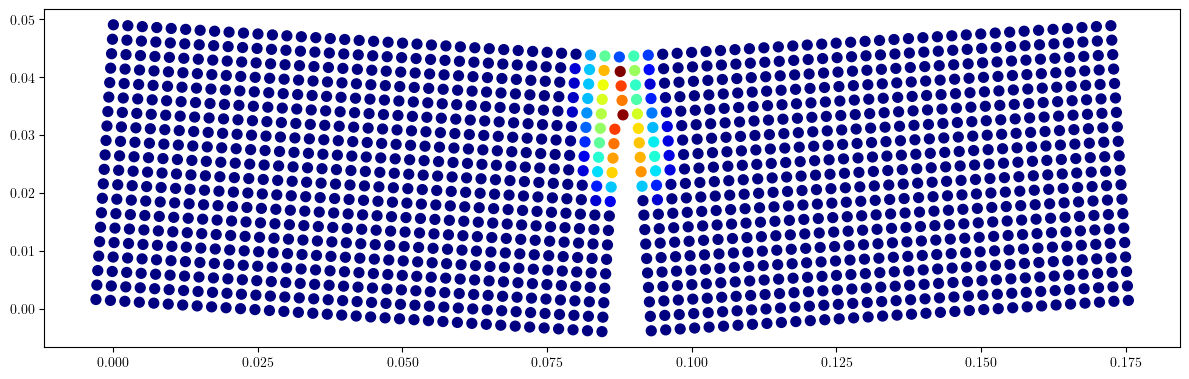

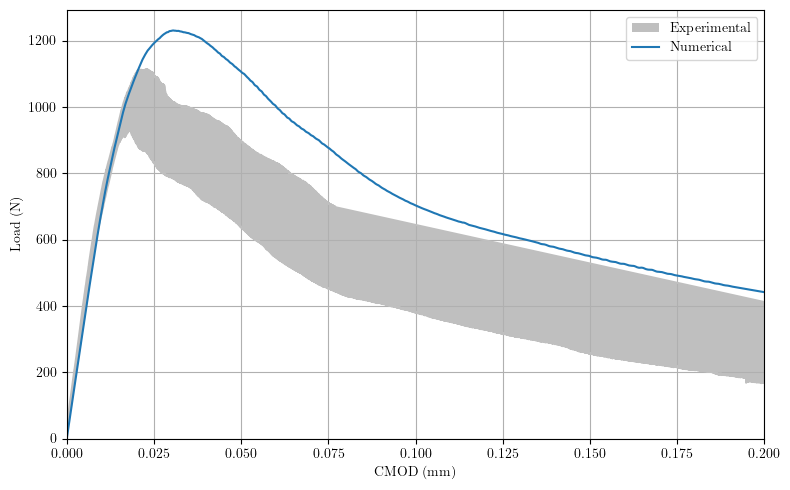

In [17]:
nonlinear_model.save_final_state_fig(sz=50, dsf=10, fig_title="half-notched-beam")
plot_load_cmod(nonlinear_model, n_div_z, fig_title="load-cmod-nonlinear")